In [1]:
import numpy as np
import math
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [4]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [5]:
def _extract_heartbeats(signal=None, rpeaks=None, before=400, after=600):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [6]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.4, after=0.6):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [7]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    print(rpeaks)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.4,after=0.6)
    if plot:
        ts_tmpl = np.linspace(-0.4, 0.6, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

In [8]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

In [9]:
def maior_valor_sinal(sinal):
    maior_valor = 0
    for i in range(len(sinal)):
        if(sinal[i] > maior_valor):
            maior_valor = sinal[i]
    return maior_valor

In [10]:
def R_peak_detection(sinal):
    sinal = filter_data(sinal,100)
    indice_aux = 0
    indice_maximo = []
    valor_aux = 0
    valor_maximo = []
    flag_contagem = 0
    indice_temp = 0
    valor_temp = 0
    i = 0
    valor_referencia = maior_valor_sinal(sinal)*0.5
    while i < len(sinal):
        if(sinal[i] > (valor_referencia)):
            indice_aux = i;
            valor_aux = sinal[i];
            for x in range(5):
                if(sinal[indice_aux+x] > valor_aux):
                    indice_temp = indice_aux + x
                    valor_temp = sinal[indice_aux + x]
                    valor_aux = sinal[indice_aux+x]
                else:
                    flag_contagem = flag_contagem + 1
            indice_maximo.append(indice_temp) 
            valor_maximo.append(valor_temp) 
            if(flag_contagem == 5):
                indice_maximo.append(i) 
                valor_maximo.append(sinal[i]) 
            flag_contagem = 0
            indice_temp = 0
            valor_temp = 0
            indice_aux = 0
            valor_aux = 0
            #print(indice_temp+i)
            #print(indice_maximo)
            i = i + 10
        i = i + 1
    contador_zeros = 0
    for j in range (len(indice_maximo)):
        if(indice_maximo[j] == 0):
            contador_zeros = contador_zeros + 1
    for k in range (len(indice_maximo) - contador_zeros):
        if(indice_maximo[k] == 0):
            indice_maximo = np.delete(indice_maximo, k)
    return indice_maximo

### Testing the final function with data collected in the SimMan simulator (SR - with noise):

In [12]:
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')

In [13]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[  56  130  204  278  353  428  502  576  651  725  802  878  954 1031
 1108 1185 1261 1338 1415 1492 1570 1646 1723 1800 1878 1955 2033 2110
 2187 2263 2338 2412 2485 2559 2632 2705 2780 2855 2930 3006 3082 3159
 3236 3312 3387 3464 3539 3615 3690 3764 3840 3916]


In [14]:
R_peak_detection(X)

[56,
 130,
 204,
 278,
 353,
 428,
 502,
 576,
 651,
 725,
 802,
 878,
 954,
 1031,
 1108,
 1185,
 1261,
 1338,
 1415,
 1492,
 1570,
 1646,
 1723,
 1800,
 1878,
 1955,
 2033,
 2110,
 2187,
 2263,
 2338,
 2412,
 2485,
 2559,
 2632,
 2705,
 2780,
 2855,
 2930,
 3006,
 3082,
 3159,
 3236,
 3312,
 3387,
 3464,
 3539,
 3615,
 3690,
 3764,
 3840,
 3916]

### Testing the final function with data collected in the SimMan simulator (SR - no noise):

In [16]:
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')

In [17]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[  65  143  218  293  367  440  515  589  662  736  809  883  957 1031
 1104 1178 1253 1328 1403 1479 1555 1631 1706 1782 1857 1933 2008 2084
 2159 2234 2309 2384 2459 2533 2608 2684 2759 2835 2912 2988]


In [18]:
R_peak_detection(X)

[65,
 143,
 218,
 293,
 367,
 440,
 515,
 589,
 662,
 736,
 809,
 883,
 957,
 1031,
 1104,
 1178,
 1253,
 1328,
 1403,
 1479,
 1555,
 1631,
 1706,
 1782,
 1857,
 1933,
 2008,
 2084,
 2159,
 2234,
 2309,
 2384,
 2459,
 2533,
 2608,
 2684,
 2759,
 2835,
 2912,
 2988]

### Testing the final function with data collected in the SimMan simulator (AFIB - with noise):

In [26]:
df = pd.read_csv("ecg_data_boneco_afib_com_ruido.csv")
X = df['values'].values.astype('float32')

In [27]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[  72  111  152  221  261  328  445  516  582  624  733  783  862  980
 1049 1116 1158 1282 1346 1405 1442 1512 1598 1724 1793 1865 1908 2039
 2077 2183 2316 2359 2481 2561 2685 2753 2821 2933 2989 3032 3102 3173
 3212 3379 3451 3493 3602 3672 3781 3848 3913 4007 4085 4137 4179 4249
 4317 4389 4454 4629 4698 4845 4976 5046 5294 5515 5623 5661 5767 5803
 5871 5978 6081 6180 6252 6375 6463 6515 6572 6729 6919 6961 7046 7084
 7127 7204 7251 7301 7367 7433 7475 7605 7647 7800 7859 7997 8132 8170
 8212 8283 8399 8515 8726 8769 8911 8949 9022]


In [28]:
R_peak_detection(X)

array([   3,   72,  111,  152,  221,  261,  328,  373,  516,  582,  624,
        665,  733,  783,  862,  911,  980, 1049, 1116, 1158, 1282, 1346,
       1405, 1442, 1512, 1560, 1598, 1667, 1724, 1793, 1865, 1908, 1980,
       2077, 2117, 2183, 2251, 2316, 2359, 2419, 2522, 2561, 2600, 2645,
       2753, 2821, 2867, 2989, 3032, 3102, 3173, 3212, 3323, 3379, 3451,
       3493, 3563, 3602, 3743, 3781, 3913, 3953, 4007, 4045, 4085, 4137,
       4179, 4249, 4317, 4389, 4454, 4493, 4558, 4629, 4698, 4778, 4845,
       4911, 4976, 5046, 5085, 5153, 5224, 5333, 5477, 5515, 5583, 5623,
       5661, 5699, 5767, 5803, 5871, 5909, 5978, 6017, 6081, 6119, 6180,
       6252, 6292, 6375, 6421, 6463, 6515, 6572, 6612, 6729, 6768, 6807,
       6879, 6919, 6961, 7046, 7084, 7127, 7166, 7204, 7251, 7301, 7367,
       7433, 7475, 7535, 7605, 7647, 7685, 7735, 7800, 7859, 7897, 7936,
       7997, 8132, 8212, 8283, 8322, 8361, 8399, 8446, 8515, 8582, 8655,
       8726, 8769, 8841, 8911, 8949, 9022, 9049, 90

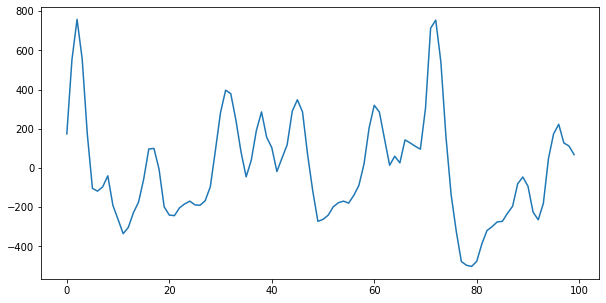

In [30]:
plt.plot(X[:100])

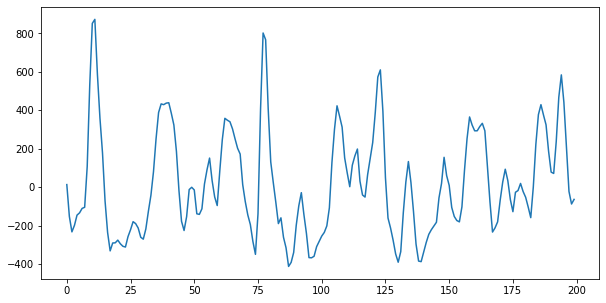

In [32]:
plt.plot(X[250:450])

### Testing the final function with data collected in the SimMan simulator (AFIB - no noise):

In [33]:
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')

In [34]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[  27   98  179  219  279  349  388  449  494  566  638  708  749  823
  896  969 1043 1107 1162 1224 1293 1354 1422 1529 1599 1668 1740 1808
 1847 1917 1989 2054 2117 2188 2256 2297 2336 2375 2416 2483 2561 2599
 2669 2707 2777 2821 2930 3040 3118 3189 3256 3327 3392 3518 3589 3663
 3714 3755 3826 3865 3909 3982 4052 4092 4189 4261 4304 4383 4454 4494
 4535 4605 4677 4719 4758 4797 4866 4906 4949 5021 5060 5129 5168 5237
 5279 5349 5416 5454 5520 5589 5660 5730 5793 5864 5906 5945 5983 6023
 6094 6164 6234 6349 6465 6570 6623 6693 6732 6776 6817 6856 6929 6983
 7055 7118 7158 7269 7309 7380 7433 7510 7581 7620 7690 7734 7803 7876
 7915 7988 8027 8068 8140 8180 8222 8261 8301 8370 8424 8464]


In [35]:
R_peak_detection(X)

array([  27,   98,  139,  179,  219,  279,  349,  388,  449,  494,  566,
        638,  708,  749,  823,  896,  969, 1043, 1107, 1162, 1224, 1293,
       1354, 1422, 1460, 1529, 1599, 1668, 1740, 1808, 1847, 1917, 1989,
       2054, 2117, 2188, 2256, 2297, 2336, 2375, 2416, 2483, 2522, 2561,
       2599, 2669, 2707, 2777, 2821, 2861, 2930, 2999, 3040, 3079, 3118,
       3189, 3256, 3327, 3392, 3454, 3518, 3589, 3663, 3714, 3755, 3826,
       3865, 3909, 3982, 4052, 4092, 4134, 4189, 4261, 4304, 4343, 4383,
       4454, 4494, 4535, 4605, 4677, 4719, 4758, 4797, 4866, 4906, 4949,
       5021, 5060, 5129, 5168, 5237, 5279, 5349, 5416, 5454, 5520, 5589,
       5660, 5730, 5793, 5864, 5906, 5945, 5983, 6023, 6094, 6164, 6234,
       6279, 6349, 6396, 6465, 6532, 6570, 6623, 6693, 6732, 6776, 6817,
       6856, 6929, 6983, 7055, 7118, 7158, 7199, 7269, 7309, 7380, 7433,
       7472, 7510, 7581, 7620, 7690, 7734, 7803, 7876, 7915, 7988, 8027,
       8068, 8140, 8180, 8222, 8261, 8301, 8370, 84

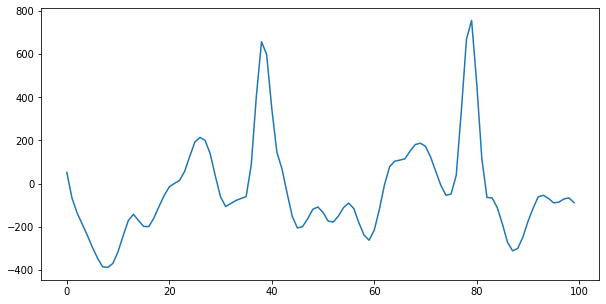

In [36]:
plt.plot(X[100:200])